<a href="https://colab.research.google.com/github/sutson/CE4145-Natural-Language-Processing-Coursework/blob/main/CE4145%20NLP%20-%20Multiclass%20Classification%20(Supplementary).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CE4145 Natural Language Processing Coursework (Supplementary) - Wilson Sutherland**
### *Attempting Multi-class Classification of the Dataset (Review Scores)*


In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nltk

"""
IMPORTANT: set the filepath from which files should be saved/loaded
"""
main_filepath = ""

In [3]:
# load the dataset from Hugging Face
from datasets import load_dataset
ds = load_dataset("auphong2707/game-reviews-sentiment")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/688 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/30.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/629884 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/78735 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/78737 [00:00<?, ? examples/s]

In [4]:
import pandas as pd

# random state for reproducibility
random_state = 11037

# convert the train
df = ds["train"].to_pandas()

# print the size of the dataset and show first 10 rows
print(f"The dataset has {df.shape[0]} rows, and {df.shape[1]} columns")
df.head(10)

The dataset has 629884 rows, and 3 columns


,review_text,review_score,review_category
0,"I like LocoRoco 2 better than the first, the m...",100,positive
1,Need for Speed: World could have been a great ...,30,negative
2,Decent game but Fairly short Pretty hard Overp...,60,mixed
3,The game looks like a great game I have been w...,100,positive
4,This game is REALLY bad! Everything is out of ...,0,negative
5,Amazing game. Graphics are ungodly. Played on ...,100,positive
6,This game story took me back to the good final...,100,positive
7,As a MSQ enjoyer this is genuinely a 3/10 stor...,10,negative
8,Nice 16bit RPG with great battle system and de...,80,positive
9,This game is extremely difficult and frustrati...,30,negative


In [5]:
def class_dist_bar(inp_df, width=7):
  """
  class_dist_bar creates a simple class distribution bar plot based on an input dataframe.

  :param inp_df: dataframe to be considered
  :param width: width of bars in the plot
  """
  # get class counts and labels from dataframe
  counts = inp_df.value_counts("review_score").sort_index()
  labels = counts.index

  # create bar chart using class distribution data
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(labels, counts, tick_label=labels, width=width, color="purple")

  # define graph labels
  plt.xlabel("Review Score")
  plt.ylabel("Number of Reviews")
  plt.title("Class Distribution of Review Scores")
  plt.xticks(labels)

  plt.show()

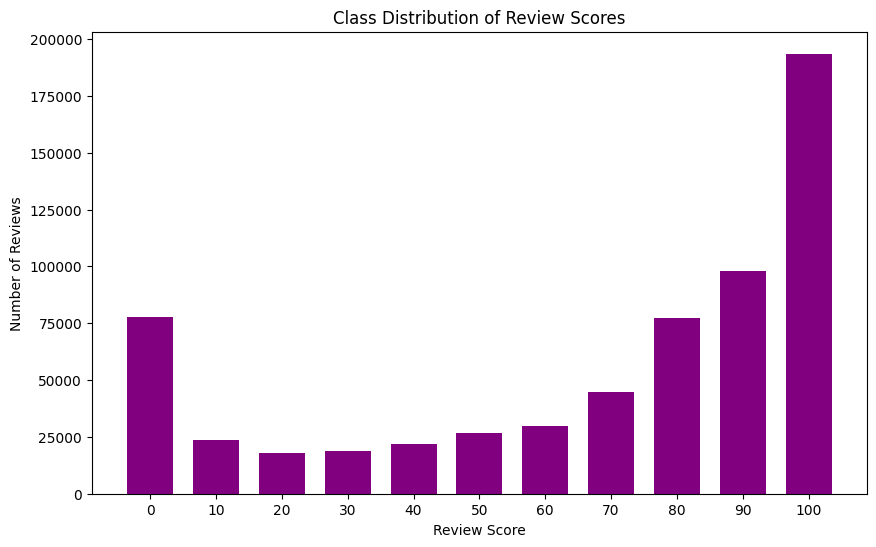

In [6]:
class_dist_bar(df)

In [7]:
df["review_score"].value_counts().sort_index()

,count
review_score,
0,77594
10,23621
20,18071
30,18889
40,21672
50,26602
60,29988
70,44778
80,77216


In [8]:
# update the dataframe to sample 1,000 reviews for each class (review score)
df = df.sample(frac=1, random_state=random_state).groupby("review_score").head(1_000)

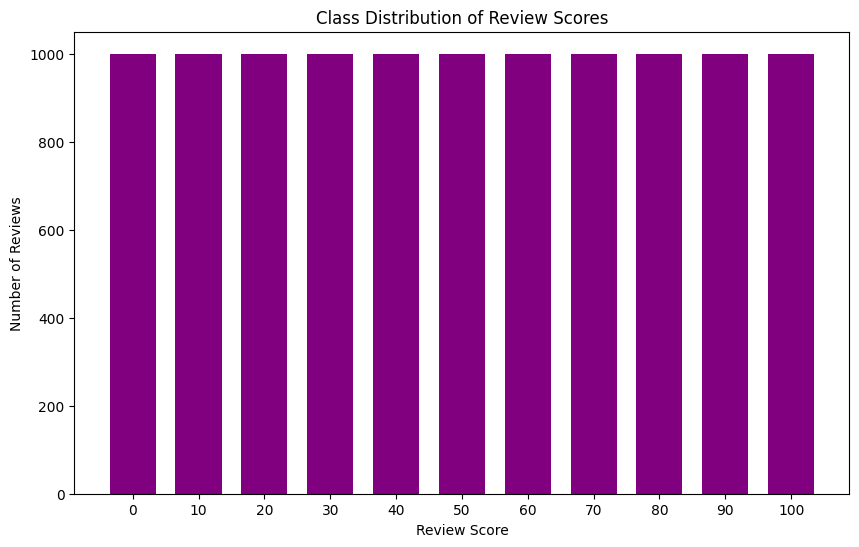

In [9]:
class_dist_bar(df)

In [10]:
import re
import inflect
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# download the following for preprocessing steps
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("words")
words = set(nltk.corpus.words.words())

# create instance of inflect for preprocessing steps
p = inflect.engine()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
def perform_number_to_text_conversion(text):
  """
  perform_number_to_text_conversion converts numbers in a text to their text-based equivalents
  for example, "412" becomes "four hundred and twelve".
  This also accounts for cases like "ps3" - the 3 here will not be converted as it is part of an abbreviation.

  :param text: string to be converted
  """
  all_numbers = re.findall(r"(?:(?<=\s)|^)\d+(?:\.\d+)?(?=\s|$)", text) # find all numbers in text
  for number in all_numbers:
    try:
      text = text.replace(number, p.number_to_words(number)) # use inflect to convert each number to words
    except:
      text = text.replace(number, "")
  return text

def perform_contraction_resolution(text):
  """
  perform_contraction_resolution resolves contractions using the contractions package.

  :param text: string to be converted
  """
  return contractions.fix(text) # use contractions package

def perform_rating_conversion(text):
  """
  perform_rating_conversion replaces instances of rating with their text-based equivalent.
  For example, "4/10" becomes "4 out of 10".

  :param text: string to be converted
  """
  return re.sub(r"(\d+)\s*/\s*(\d+)", r"\1 out of \2", text)

def perform_punctuation_removal(text):
  """
  perform_punctuation_removal removes all punctuation from the input text.

  :param text: string to be converted
  """
  return re.sub(r"[^a-zA-Z0-9]+", " ", text)

def perform_censorship_conversion(text):
  """
  perform_censorship_conversion converts censored words (represented by multiple asterisks in a row) to "curseword".

  :param text: string to be converted
  """
  return re.sub(r"\*+", "curseword", text)

def perform_url_removal(text):
  """
  perform_url_removal removes any instances of URL strings in the text.
  It was found that some URLs in the dataset started with **** so these have to be removed as well.

  :param text: string to be converted
  """
  url_regex = re.compile(r"(?:https?://|\*\*\*\*)/\S+") # finds URLs starting with http://, https:// or ****/

  return url_regex.sub("", text)

# create simple map from symbol to replacement text
symbol_dict = {
    "£": "pound",
    "$": "dollar",
    "¢": "cent",
    "€": "euro",
    "%": "percent",
    "&": "and",
    "@": "at"
}

def perform_common_symbol_conversion(text):
  """
  perform_common_symbol_conversion converts common symbols like "$" to text (i.e. "dollar").
  This changes "$10" to "10 dollar" and "@" to "at" as some people use these symbols in their reviews.

  :param text: string to be converted
  """
  # perform start of number symbol conversion (eg. "$10" -> "10 dollar")
  text = re.sub(
    r"([£$€])(\d+(?:\.\d+)?)",
    lambda m: f"{m.group(2)} {symbol_dict[m.group(1)]}",
    text
  )

  # perform end of number symbol conversion (eg. "10%" -> "10 percent")
  text = re.sub(
    r"(\d+(?:\.\d+)?)([¢%])",
    lambda m: f"{m.group(1)} {symbol_dict[m.group(2)]}",
    text
  )

  # perform conversion of "@" and "&"
  for symbol in ["@", "&"]:
    text = text.replace(symbol, f"{symbol_dict[symbol]}")

  return text.strip()

def perform_stop_word_removal(text):
  """
  perform_stop_word_removal removes stop words based on the nltk package
  This includes short words which provide no additional information like "is" and "a"

  :param text: string to be converted
  """
  sentence = text.split()
  return " ".join([word for word in sentence if word not in stopwords.words("english")])

def perform_stemming(text):
  """
  perform_stemming carries out the stemming procedure using the nltk package
  This truncates words to their root form, for example "playing" -> "play"

  :param text: string to be converted
  """
  stemmer = SnowballStemmer("english") # specify English stemming rules
  sentence = text.split()
  return " ".join([stemmer.stem(word) for word in sentence])

In [12]:
def preprocess(dframe):
  """
  preprocess carries out preprocessing steps to an input dataframe.

  :param dframe: dataframe to be preprocessed
  """
  dframe["review_text"] = dframe["review_text"].apply(lambda x: x.lower())
  dframe["review_text"] = dframe["review_text"].apply(perform_url_removal)
  dframe["review_text"] = dframe["review_text"].apply(perform_common_symbol_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_censorship_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_contraction_resolution)
  dframe["review_text"] = dframe["review_text"].apply(perform_rating_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_punctuation_removal)
  dframe["review_text"] = dframe["review_text"].apply(perform_number_to_text_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_stop_word_removal)
  dframe["review_text"] = dframe["review_text"].apply(perform_stemming)

  return dframe

In [13]:
df = preprocess(df)
df.head(10)

,review_text,review_score,review_category
391816,bad joke want game bad thank seen far wake ea ...,10,negative
333675,dark soul two compar predecessor fall slight s...,90,positive
610364,game tri teach us think studio stood bulli gre...,90,positive
547680,could made game much mani annoy aspect game we...,30,negative
183105,game think expect linear game memor moment rea...,30,negative
479486,ok averag game run around world catch pok mon ...,50,mixed
427934,absolut amaz game blew expect water stori grip...,100,positive
439459,perhap judgment cloud rose color memori origin...,90,positive
465161,start state textur issu occur mean player turn...,80,positive
417108,best cod time day one gamepass thank microsoft...,100,positive


## Representation Learning

In [14]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 33.4 MB/s eta 0:00:00


In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_confusion_matrix_plot(con_matrix, title, colour = "Blues"):
  """
  create_confusion_matrix_plot creates a single confusion matrix plot based on several inputs.

  :param con_matrix: confusion matrix to be plotted
  :param title: title of plot
  :param colour: colour palette to be used, defaults to Blues
  """
  # create heatmap which serves as the visual representation of the confusion matrix
  sns.heatmap(
    con_matrix,
    annot=True,
    fmt="d",
    cmap=colour,
    xticklabels=sorted(df["review_score"].unique()),
    yticklabels=sorted(df["review_score"].unique()),
  )

  # change plot attributes
  plt.title(f"\nConfusion Matrix - {title}\n")
  plt.xlabel("\nPredicted")
  plt.ylabel("True\n")
  plt.figure(figsize=(20,10))

  plt.tight_layout()
  plt.show()

def create_combined_confusion_matrix_plots(con_matrices, titles, colours, fig_width):
  """
  create_combined_confusion_matrix_plots creates a combined plot of several confusion matrix plot based on several inputs.

  :param con_matrices: confusion matrices to be plotted
  :param titles: array of titles of plots
  :param colour: array of colour palettes to be used for each individual plot
  :param fig_width: width of overall figure
  """
  # initialise subplots
  fig, axes = plt.subplots(1, len(con_matrices), figsize=(fig_width, 6))

  # loop over each confusion matrix and plot a heatmap for it
  for i, con_matrix in enumerate(con_matrices):
    sns.heatmap(
        con_matrix,
        annot=True,
        fmt="d",
        cmap=colours[i],
        ax=axes[i],
        yticklabels = df["review_score"].unique(),
        xticklabels = df["review_score"].unique(),
    )

    # set plot attributes
    axes[i].set_title("\n" + titles[i] + "\n")
    axes[i].set_xlabel("\nPredicted")
    axes[i].set_ylabel("True\n")

  plt.tight_layout()
  plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = np.array(df["review_text"]) # define independent features, i.e. review text
y = df["review_score"].values # define labels

# create train/test splits (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

### Word-2-Vector (Word2Vec)

In [17]:
from gensim.models import Word2Vec

def create_word2vec_rep(sentence, word2vec_model):
  """
  create_word2vec_rep generates a Word2Vec representation based on input text.

  :param sentence: sentence to be converted into the Word2Vec representation
  :param word2vec_model: Word2Vec model
  """
  embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv.index_to_key] # get word embeddings
  if embeddings:
    return np.mean(np.array(embeddings), 0) # return average of embeddings
  else:
    return np.zeros(word2vec_model.vector_size) # return zero vector with correct dimensions in case of some error to prevent dimensional mismatching

In [18]:
# instantiate, build and train the Word2Vec model
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=3, workers=4)
word2vec_model.build_vocab(X_train, update=None)
word2vec_model.train(corpus_iterable=X_train, total_examples=len(X_train), epochs=100)

# get the representation of the input data based on Word2Vec model we just trained
X_train_rep_word2vec = [create_word2vec_rep(instance, word2vec_model) for instance in X_train]
X_test_rep_word2vec = [create_word2vec_rep(instance, word2vec_model) for instance in X_test]

# create basic Logistic Regression model to fit the data
model_lr_word2vec = LogisticRegression(max_iter=1000, random_state=random_state)
model_lr_word2vec.fit(X_train_rep_word2vec, y_train)

# predict outcomes based on model
y_pred_lr_word2vec = model_lr_word2vec.predict(X_test_rep_word2vec)

# show classification report to display metrics
print("\nLogistic Regression Model (Word2Vec):\n", classification_report(y_test, y_pred_lr_word2vec))


Logistic Regression Model (Word2Vec):
               precision    recall  f1-score   support

           0       0.13      0.20      0.16       200
          10       0.18      0.09      0.12       221
          20       0.12      0.10      0.11       204
          30       0.10      0.06      0.08       205
          40       0.11      0.15      0.13       184
          50       0.12      0.09      0.10       199
          60       0.15      0.18      0.17       206
          70       0.08      0.05      0.06       203
          80       0.12      0.10      0.11       182
          90       0.15      0.10      0.12       195
         100       0.14      0.33      0.20       201

    accuracy                           0.13      2200
   macro avg       0.13      0.13      0.12      2200
weighted avg       0.13      0.13      0.12      2200



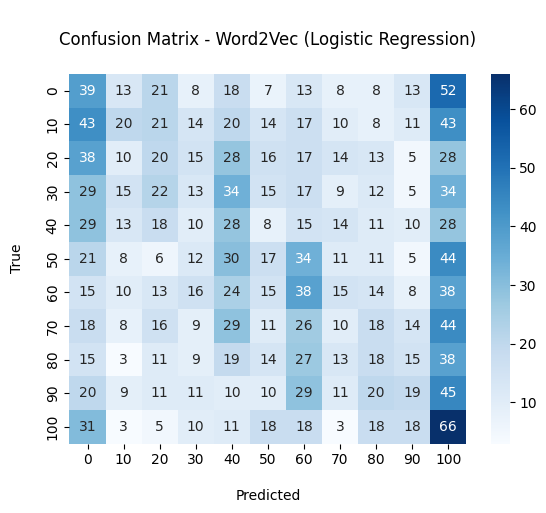

<Figure size 2000x1000 with 0 Axes>

In [19]:
# create confusion matrix based on Logistic Regression model and plot it
con_matrix_lr_word2vec = confusion_matrix(y_test, y_pred_lr_word2vec)
create_confusion_matrix_plot(con_matrix_lr_word2vec, "Word2Vec (Logistic Regression)")

### GloVe

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

"""
To work with GloVe, download the glove.6B.zip file from https://nlp.stanford.edu/projects/glove/
Extract the zip file and put the glove.6B.100d.txt file in the main_filepath directory.
The following code should be run once to generate the Word2Vec format required by gensim, after which it may be commented out.
"""
# create GloVe filepaths for input and output files
glove_input_file = f"{main_filepath}/glove.6B.100d.txt"
word2vec_output_file = f"{main_filepath}/glove.6B.100d.word2vec.txt"

glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
from gensim.models import KeyedVectors

# load the GloVe vectors from file
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [22]:
def create_glove_rep(sentence, glove_model):
  """
  create_glove_rep generates a GloVe representation based on input text.

  :param sentence: sentence to be converted into the GloVe representation
  :param glove_model: GloVe model
  """
  embeddings = [glove_model[word] for word in sentence if word in glove_model] # get word embeddings
  if embeddings:
    return np.mean(embeddings, 0) # return average of embeddings
  else:
    return np.zeros(glove_model.vector_size) # return zero vector with correct dimensions in case of some error to prevent dimensional mismatching

In [23]:
# get the representation of the input data based on GloVe model
X_train_rep_glove = [create_glove_rep(instance, glove_model) for instance in X_train]
X_test_rep_glove = [create_glove_rep(instance, glove_model) for instance in X_test]

# create basic Logistic Regression model to fit the data
model_lr_glove = LogisticRegression(max_iter=1000, random_state=random_state)
model_lr_glove.fit(X_train_rep_glove, y_train)

# predict outcomes based on model
y_pred_lr_glove = model_lr_glove.predict(X_test_rep_glove)

# show classification report to display metrics
print("\nLogistic Regression Model (GloVe):\n", classification_report(y_test, y_pred_lr_glove))


Logistic Regression Model (GloVe):
               precision    recall  f1-score   support

           0       0.15      0.29      0.20       200
          10       0.12      0.05      0.07       221
          20       0.15      0.09      0.11       204
          30       0.12      0.07      0.09       205
          40       0.10      0.12      0.11       184
          50       0.15      0.10      0.12       199
          60       0.12      0.12      0.12       206
          70       0.10      0.08      0.09       203
          80       0.13      0.15      0.14       182
          90       0.17      0.12      0.14       195
         100       0.16      0.32      0.21       201

    accuracy                           0.14      2200
   macro avg       0.13      0.14      0.13      2200
weighted avg       0.13      0.14      0.13      2200



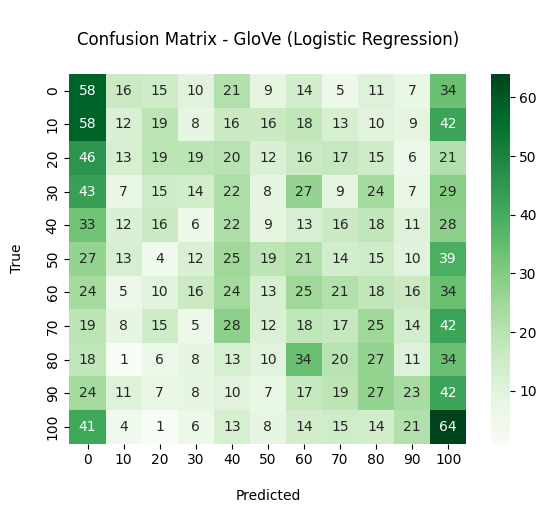

<Figure size 2000x1000 with 0 Axes>

In [24]:
# create confusion matrix based on Logistic Regression model and plot it
con_matrix_lr_glove = confusion_matrix(y_test, y_pred_lr_glove)
create_confusion_matrix_plot(con_matrix_lr_glove, "GloVe (Logistic Regression)", "Greens")

### Document-2-Vector (Doc2Vec)

In [25]:
from gensim.models.doc2vec import TaggedDocument

def create_doc2vec_rep(data):
  """
  create_doc2vec_rep generates a Doc2Vec representation based on input data.
  The data is converted into TaggedDocument objects, each of which is a list of words
  with a unique tag which lets us train the Doc2Vec model.

  :param data: text data to be converted into the Doc2Vec representation
  """
  return [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(data)]

# Apply the tagging function to training and testing data
def create_corpora(X_train, X_test):
  """
  create_corpora generates the train and test corpora based on the Doc2Vec representation.

  :param X_train: train text data
  :param X_test: test text data
  """
  train_corpus = create_doc2vec_rep(X_train)
  test_corpus = create_doc2vec_rep(X_test)
  return train_corpus, test_corpus

In [26]:
from gensim.models.doc2vec import Doc2Vec

# generate train and test corpora
train_corpus, test_corpus = create_corpora(X_train, X_test)

# instantiate, build and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=300, window=5, min_count=3, workers=4, epochs=100)
doc2vec_model.build_vocab(train_corpus)
doc2vec_model.train(train_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# get the representation of the input data based on Doc2Vec model we just trained
X_train_rep_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in train_corpus]
X_test_rep_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in test_corpus]

# create basic Logistic Regression model to fit the data
model_lr_doc2vec = LogisticRegression(max_iter=1000, random_state=random_state)
model_lr_doc2vec.fit(X_train_rep_doc2vec, y_train)

# predict outcomes based on model
y_pred_lr_doc2vec = model_lr_doc2vec.predict(X_test_rep_doc2vec)

# show classification report to display metrics
print("\nLogistic Regression Model (Doc2Vec):\n", classification_report(y_test, y_pred_lr_doc2vec))


Logistic Regression Model (Doc2Vec):
               precision    recall  f1-score   support

           0       0.21      0.51      0.30       200
          10       0.16      0.17      0.16       221
          20       0.16      0.08      0.11       204
          30       0.14      0.09      0.11       205
          40       0.12      0.05      0.07       184
          50       0.20      0.08      0.11       199
          60       0.18      0.11      0.14       206
          70       0.22      0.13      0.16       203
          80       0.18      0.23      0.20       182
          90       0.24      0.30      0.26       195
         100       0.30      0.55      0.38       201

    accuracy                           0.21      2200
   macro avg       0.19      0.21      0.18      2200
weighted avg       0.19      0.21      0.18      2200



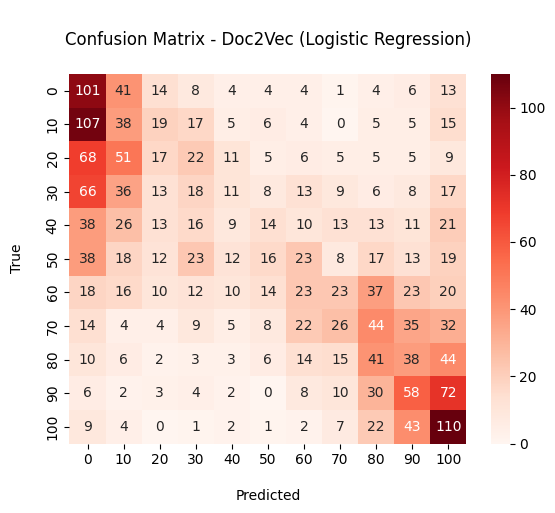

<Figure size 2000x1000 with 0 Axes>

In [27]:
# create confusion matrix based on Logistic Regression model and plot it
con_matrix_lr_doc2vec = confusion_matrix(y_test, y_pred_lr_doc2vec)
create_confusion_matrix_plot(con_matrix_lr_doc2vec, "Doc2Vec (Logistic Regression)", "Reds")

### Comparison of the Three Representation Learners

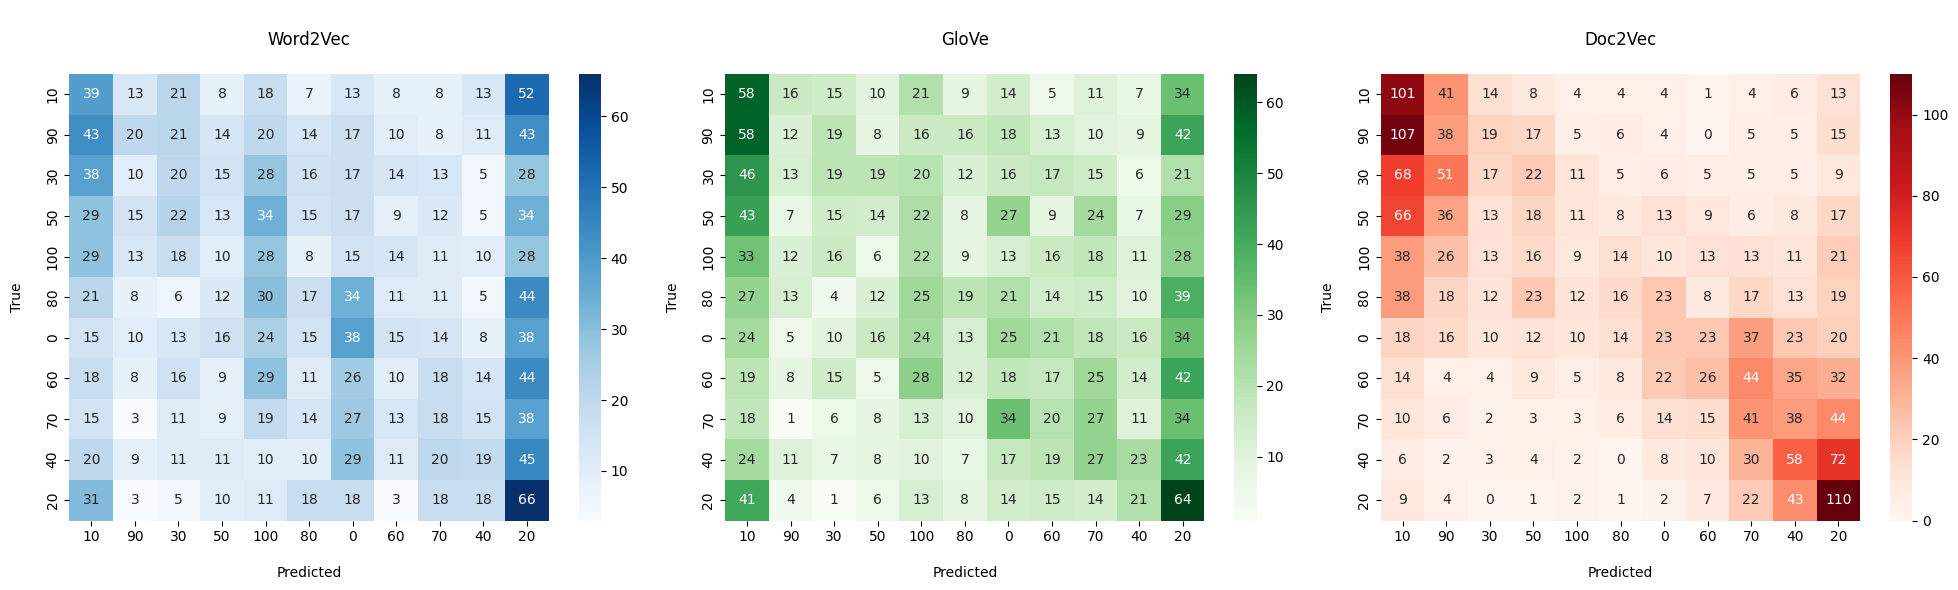

In [28]:
# plot combined confusion matrices to compare the results
create_combined_confusion_matrix_plots(
  [con_matrix_lr_word2vec, con_matrix_lr_glove, con_matrix_lr_doc2vec],
  ["Word2Vec", "GloVe", "Doc2Vec"],
  ["Blues", "Greens", "Reds"],
  20
)